Authors: Luís Eduardo Anunciado Silva, Mayra Dantas de Azevedo



---



In [1]:
!pip install unidecode
!pip install geopandas


     |████████████████████████████████| 245kB 4.8MB/s 
     |████████████████████████████████| 901kB 5.3MB/s 
     |████████████████████████████████| 17.9MB 21.3MB/s 
     |████████████████████████████████| 10.8MB 27.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
import requests
import json

import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import unidecode

## Recovering data about indicators from the API

In this section, we use the [Sidra API](http://api.sidra.ibge.gov.br) to recover the neighborhoods, as well as some informations about the average income and other indicators.

In [0]:
# income by neighborhood in Natal (2010)
# from Sidra's Table 3170 (http://api.sidra.ibge.gov.br/desctabapi.aspx?c=3170)
headers = {
    'Content-Type': 'application/json;charset=UTF-8',
    'User-Agent': 'google-colab',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7',
    'Connection': 'keep-alive',
}


endnode = "http://api.sidra.ibge.gov.br/values/t/3170/p/2010/v/842/N102/in%20n6%202408102"

response = requests.get(endnode,headers=headers)

# for curiosity, take a look in this variable
raw_data_income = response.json()


The variable 842 gave us the information about the income, now with the variable 841 we get the population of each neighborhood.

In [0]:
# Recover the number of inhabitants
endnode_people = "http://api.sidra.ibge.gov.br/values/t/3170/p/2010/v/841/N102/in%20n6%202408102"

response = requests.get(endnode_people,headers=headers)

# for curiosity, take a look in this variable
raw_data_people = response.json()

In [5]:
# Show the code of each column as well as 
# its name
raw_data_income[0]

{'D1C': 'Ano (Código)',
 'D1N': 'Ano',
 'D2C': 'Variável (Código)',
 'D2N': 'Variável',
 'D3C': 'Bairro (Código)',
 'D3N': 'Bairro',
 'D4C': 'Situação do domicílio (Código)',
 'D4N': 'Situação do domicílio',
 'D5C': 'Sexo (Código)',
 'D5N': 'Sexo',
 'D6C': 'Grupo de idade (Código)',
 'D6N': 'Grupo de idade',
 'MC': 'Unidade de Medida (Código)',
 'MN': 'Unidade de Medida',
 'V': 'Valor'}

In [0]:
income_df = pd.DataFrame(raw_data_income, columns=['D3C', 'D3N', 'V'])
income_df.drop(labels=0, inplace=True)

In [0]:
people_df = pd.DataFrame(raw_data_people, columns=['D3C', 'V'])
people_df.drop(labels=0, inplace=True)

Now we need to combine these variables and rename the columns.

In [0]:
neighborhood_df = income_df.merge(people_df, on='D3C')

In [9]:
neighborhood_df.head()

,D3C,D3N,V_x,V_y
0,2408102001,Santos Reis - Natal - RN,984.31,2989
1,2408102002,Praia do Meio - Natal - RN,1658.16,2810
2,2408102003,Rocas - Natal - RN,969.39,5806
3,2408102004,Ribeira - Natal - RN,2825.82,1453
4,2408102005,Petrópolis - Natal - RN,4736.63,3288


In [0]:
new_columns = {'V_x':'income', 'D3C':'id', 'D3N':'name', 'V_y':'inhabitants'}

neighborhood_df.rename(columns=new_columns, inplace=True)

In [0]:
neighborhood_df['name'] = neighborhood_df.name.str.split(pat=' - ', n=1, expand=True)[0]

We choose to remove any symbols from the name in order to facilitate the match with the names from the geojson, which will be done at the next section

In [0]:
neighborhood_df['name_norm'] = neighborhood_df.name.apply(lambda x:unidecode.unidecode(x))

In [13]:
neighborhood_df.name.unique()

array(['Santos Reis', 'Praia do Meio', 'Rocas', 'Ribeira', 'Petrópolis',
       'Areia Preta', 'Mãe Luíza', 'Tirol', 'Cidade Alta', 'Lagoa Seca',
       'Alecrim', 'Quintas', 'Nordeste', 'Bom Pastor',
       'Cidade da Esperança', 'Dix-Sept Rosado', 'Lagoa Nova',
       'Nova Descoberta', 'Candelária', 'Cidade Nova', 'Filipe Camarão',
       'Guarapés', 'Pitimbú', 'Neópolis', 'Capim Macio', 'Ponta Negra',
       'Igapó', 'Nossa Senhora da Apresentação', 'Potengi', 'Salinas',
       'Lagoa Azul', 'Pajuçara', 'Redinha', 'Barro Vermelho',
       'Nossa Senhora de Nazaré', 'Planalto'], dtype=object)

In [14]:
neighborhood_df.query("name == 'Pitimbú' ")

,id,name,income,inhabitants,name_norm
22,2408102023,Pitimbú,2014.20,15049,Pitimbu


## Retrieving the centroid of each neighborhood

In this section, we use the geojson from Natal to discover the centroid of each polygon that describes a neighborhood. This will be used to calculate the distance between the center of a neighboorhod and any category of point of interest (school, hospital, bank...)

In [0]:
# load the GeoJSON data and use 'UTF-8'encoding
geojson_natal_file = requests.get('https://github.com/nymarya/data-science-one/blob/master/Lesson%2314/natal.geojson?raw=true')
geo_json_natal = geojson_natal_file.json()

The [geopandas](http://geopandas.org/) module will help us to recover the polygon that describes the boundaries of each area.

In [0]:
with open('natal.geojson', 'w') as outfile:  
    json.dump(geo_json_natal, outfile)

In [0]:
geojson_df = gpd.read_file("natal.geojson")

In [18]:
geojson_df.head()

,id,@id,admin_level,boundary,is_in,name,place,type,alt_name,wikidata,geometry
0,relation/388146,relation/388146,10,administrative,Natal,Pitimbu,suburb,boundary,None,None,"POLYGON ((-35.2437294 -5.8420332, -35.2437895 ..."
1,relation/388147,relation/388147,10,administrative,Natal,Planalto,suburb,boundary,None,None,"POLYGON ((-35.2538208 -5.8662863, -35.2536119 ..."
2,relation/397022,relation/397022,10,administrative,Natal,Ponta Negra,suburb,boundary,None,None,"POLYGON ((-35.1890225 -5.8907943, -35.1889493 ..."
3,relation/1230018,relation/1230018,10,administrative,Natal,Neópolis,suburb,boundary,None,None,"POLYGON ((-35.2003077 -5.8734101, -35.1999644 ..."
4,relation/1230020,relation/1230020,10,administrative,Natal,Capim Macio,suburb,boundary,None,None,"POLYGON ((-35.1894621 -5.8724223, -35.1890659 ..."


In [0]:
# Fix typo
typo_df = geojson_df.query('name == "Felipe Camarão"')

geojson_df.loc[typo_df.index.values, 'name'] = 'Filipe Camarão'

In [0]:
neighborhood_df['x'] = pd.Series()
neighborhood_df['y'] = pd.Series()

for index, data in geojson_df.iterrows():
  name = unidecode.unidecode(data['name'])
  # Get the polygon
  polygon = Polygon(data['geometry'])
  
  # Get neighbourhood
  neigh = neighborhood_df.query('name_norm == "' + name +'"')
  neighborhood_df.loc[neigh.index.values[0], 'x'] = polygon.centroid.x
  neighborhood_df.loc[neigh.index.values[0], 'y'] = polygon.centroid.y

## Calculating distances

In [21]:
!pip install osmnx
!pip install pandana

     |████████████████████████████████| 71kB 4.5MB/s 
     |████████████████████████████████| 112kB 4.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/1b/6b/8e/d407b4024967083177d62b39840e9099df050a8d5967f174cc
Successfully built pandana


In [0]:
import osmnx as ox
from osmnx.utils import get_nearest_node

With the help of the [osmnx](https://osmnx.readthedocs.io/en/stable/osmnx.html) module, we obtain the graph corresponding to the city Natal by using the function `graph_from_address`.

We also are able to 

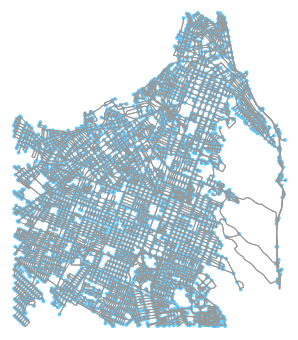

In [23]:
distance = 4000
city_address = 'Natal, Rio Grande do Norte'
G = ox.graph_from_address(city_address,distance = distance)
cityGraph, axes = ox.plot_graph(G)

## Retrieving the points of interest

By consulting the `pois_from_address`, we are able to find all the points of interestin within the city_address.

In [0]:
amenities = ['hospital', 'clinic', 'restaurant','cafe','school','bank','pharmacy']

all_pois = ox.pois.pois_from_address(city_address, distance, amenities=amenities)

In [0]:
all_pois.dropna(axis='index', subset=['amenity'], inplace=True)

In [26]:
all_pois[['amenity', 'name', 'osmid']].head()

,amenity,name,osmid
492906773,pharmacy,Farmácia Pague Menos,492906773
501152457,restaurant,Restaurante da APURN,501152457
501152488,pharmacy,NaN,501152488
501152491,restaurant,NaN,501152491
501170997,school,Centro de Atenção Integral a Criança e ao Adol...,501170997


## Gettting nearet points

After adding the points of interest to the graph, we are able to retrieve the nearest node in the graph, as well as the distance to it.

In [0]:
for id, geo in all_pois[['osmid', 'geometry']].values :
  if(type(geo) == Point):
    G.add_node(id, x=geo.x, y=geo.y, osmid=id)

In [0]:
nodes = G.nodes(data=True)
def get_dict(p_id, lat, lon, amenity):
  """ Create a dict with the result of the query
  of the nearest amenity for a centroid of a neighbourhood
  """
  
  # Get points of interest by category
  pois = all_pois.query('amenity == "' + amenity + '"').reset_index()
  amenities_ids = pois.osmid.unique()
  
  # Get the subgraph which contains
  selected_nodes = [n for n,v in nodes if (v['osmid']) in amenities_ids]  
  H = G.subgraph(selected_nodes)
  
  # Calculate distance in meters
  nearest_node = get_nearest_node(H, (lat, lon), return_dist=True)
  
  # Gather all the information
  dictionary = {}
  dictionary['id'] = p_id
  dictionary['distance'] = nearest_node[1]
  dictionary['amenity'] = amenity
  
  return dictionary

In [0]:
# Calculate distance by amenity
distances = []
for amenity in amenities:
  
  # Get nearest node
  points = neighborhood_df[['id', 'x', 'y']].values
  dists = [get_dict(p_id, y, x,amenity) for p_id, x, y in points ]
  distances += dists

In [34]:
# Check out the result
distances[:5]

[{'amenity': 'hospital', 'distance': 984.5122715584691, 'id': '2408102001'},
 {'amenity': 'hospital', 'distance': 451.4048026471281, 'id': '2408102002'},
 {'amenity': 'hospital', 'distance': 459.9160453354818, 'id': '2408102003'},
 {'amenity': 'hospital', 'distance': 353.9048328028821, 'id': '2408102004'},
 {'amenity': 'hospital', 'distance': 273.36369187803774, 'id': '2408102005'}]

Based on the dictionary above, we create a dataframe in order to tidy our data and separate the distance by amenity and prepare the information to be included on the final dataframe.

In [0]:
distances_df = pd.DataFrame(distances)

In [36]:
distances_df.head()

,amenity,distance,id
0,hospital,984.512272,2408102001
1,hospital,451.404803,2408102002
2,hospital,459.916045,2408102003
3,hospital,353.904833,2408102004
4,hospital,273.363692,2408102005


In [0]:
distances_df = distances_df.pivot_table(values='distance', index='id',
                                        columns='amenity', aggfunc='mean')

In [38]:
distances_df.head()

amenity,bank,cafe,clinic,hospital,pharmacy,restaurant,school
id,,,,,,,
2408102001,2592.872330,8818.120855,2152.020155,984.512272,1820.830309,1603.613054,1440.366954
2408102002,1429.247514,7159.800094,839.344240,451.404803,607.239551,700.421122,484.403965
2408102003,1435.384666,7558.165086,897.160925,459.916045,644.670144,515.459156,298.302111
2408102004,968.081563,7252.817376,738.930950,353.904833,332.049100,172.058573,872.659775
2408102005,755.508891,6454.735455,211.764640,273.363692,339.971113,177.285033,1008.422400


Given the distance of the centroid of the neighborhood, we now add this information to the data set

In [0]:
neighborhood_df = neighborhood_df.merge(distances_df, on='id', how='left')

# Update columns name
new_columns = { amenity: 'distance_'+amenity for amenity in amenities}
neighborhood_df.rename(columns=new_columns, inplace=True)

In [40]:
neighborhood_df.head()

,id,name,income,inhabitants,name_norm,x,y,distance_bank,distance_cafe,distance_clinic,distance_hospital,distance_pharmacy,distance_restaurant,distance_school
0,2408102001,Santos Reis,984.31,2989,Santos Reis,-35.199888,-5.762731,2592.872330,8818.120855,2152.020155,984.512272,1820.830309,1603.613054,1440.366954
1,2408102002,Praia do Meio,1658.16,2810,Praia do Meio,-35.195083,-5.778860,1429.247514,7159.800094,839.344240,451.404803,607.239551,700.421122,484.403965
2,2408102003,Rocas,969.39,5806,Rocas,-35.200216,-5.774142,1435.384666,7558.165086,897.160925,459.916045,644.670144,515.459156,298.302111
3,2408102004,Ribeira,2825.82,1453,Ribeira,-35.205768,-5.776236,968.081563,7252.817376,738.930950,353.904833,332.049100,172.058573,872.659775
4,2408102005,Petrópolis,4736.63,3288,Petropolis,-35.198393,-5.784591,755.508891,6454.735455,211.764640,273.363692,339.971113,177.285033,1008.422400


Finally, let's just check if any entry is null.

In [41]:
neighborhood_df.isna().sum()

id                     0
name                   0
income                 0
inhabitants            0
name_norm              0
x                      0
y                      0
distance_bank          0
distance_cafe          0
distance_clinic        0
distance_hospital      0
distance_pharmacy      0
distance_restaurant    0
distance_school        0
dtype: int64

## Saving the dataset

In [0]:
neighborhood_df.to_csv('neighbourhoods.csv')